## Splink deduplication demo 

In this demo we de-duplicate a dataset.  The dataset is small (1000) rows to enable the tutorial to be run interactively, but readers should imagine the true dataset is large (millions of rows).

This is a comprehensive example in which we demonstrate the full range of functionality of Splink, and how it is intended to be used.  A quickstart notebook is provided [here](quickstart_demo_deduplication.ipynb).

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark() # See utility_functions/demo_utils.py for how to set up Spark

## Step 2:  Read in data

Note that the `group` column is the truth - rows which share the same value refer to the same person.  In the real world, we wouldn't have this field because this is the truth - the label which Splink is trying to estimate.

In [4]:
df = spark.read.csv("data/fake_1000.csv", header=True)
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Robert|   Alan|1971-06-24|  null| robert255@smith.net|    0|
|        1|    Robert|  Allen|1971-05-24|  null| roberta25@smith.net|    0|
|        2|       Rob|  Allen|1971-06-24|London| roberta25@smith.net|    0|
|        3|    Robert|   Alen|1971-06-24| Lonon|                null|    0|
|        4|     Grace|   null|1997-04-26|  Hull|grace.kelly52@jon...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Step 3:  Profile the data

Understanding your data through the use of summary statistics is critical. 

For the purposes of data linking, one of the most important attributes of your data is cardinality.  Fields like date of birth which have a large number of unique values (high cardinality) are more useful than fields with low cardinality like gender.

Another important attribute is skew, which can occur:
1. because values (like a first name of John) occur more frequently in the real world
2. due to data quality issues (such as a large number of date of birth fields containing the value '1970-01-01' due errors in date parsing)

In the case of (1), you should turn on `term_frequency_adjustments` for the relevant column.  For (2), you shoud clean up these values prior to linkage.  For example, if a string value like `1970-01-01` indicates a null, you should explicitly null out these values.

Splink provides a profiling tool to for you to visually inspect value frequencies, which we can see as follows:

In the case of our test dataset, there is a moderate level of skew, partcularly on the first_name, surname and city columns.  We can see most of our fields have high cardinality.

We also observe that misspellings are common across most fields.

In [5]:
from splink.profile import column_value_frequencies_chart

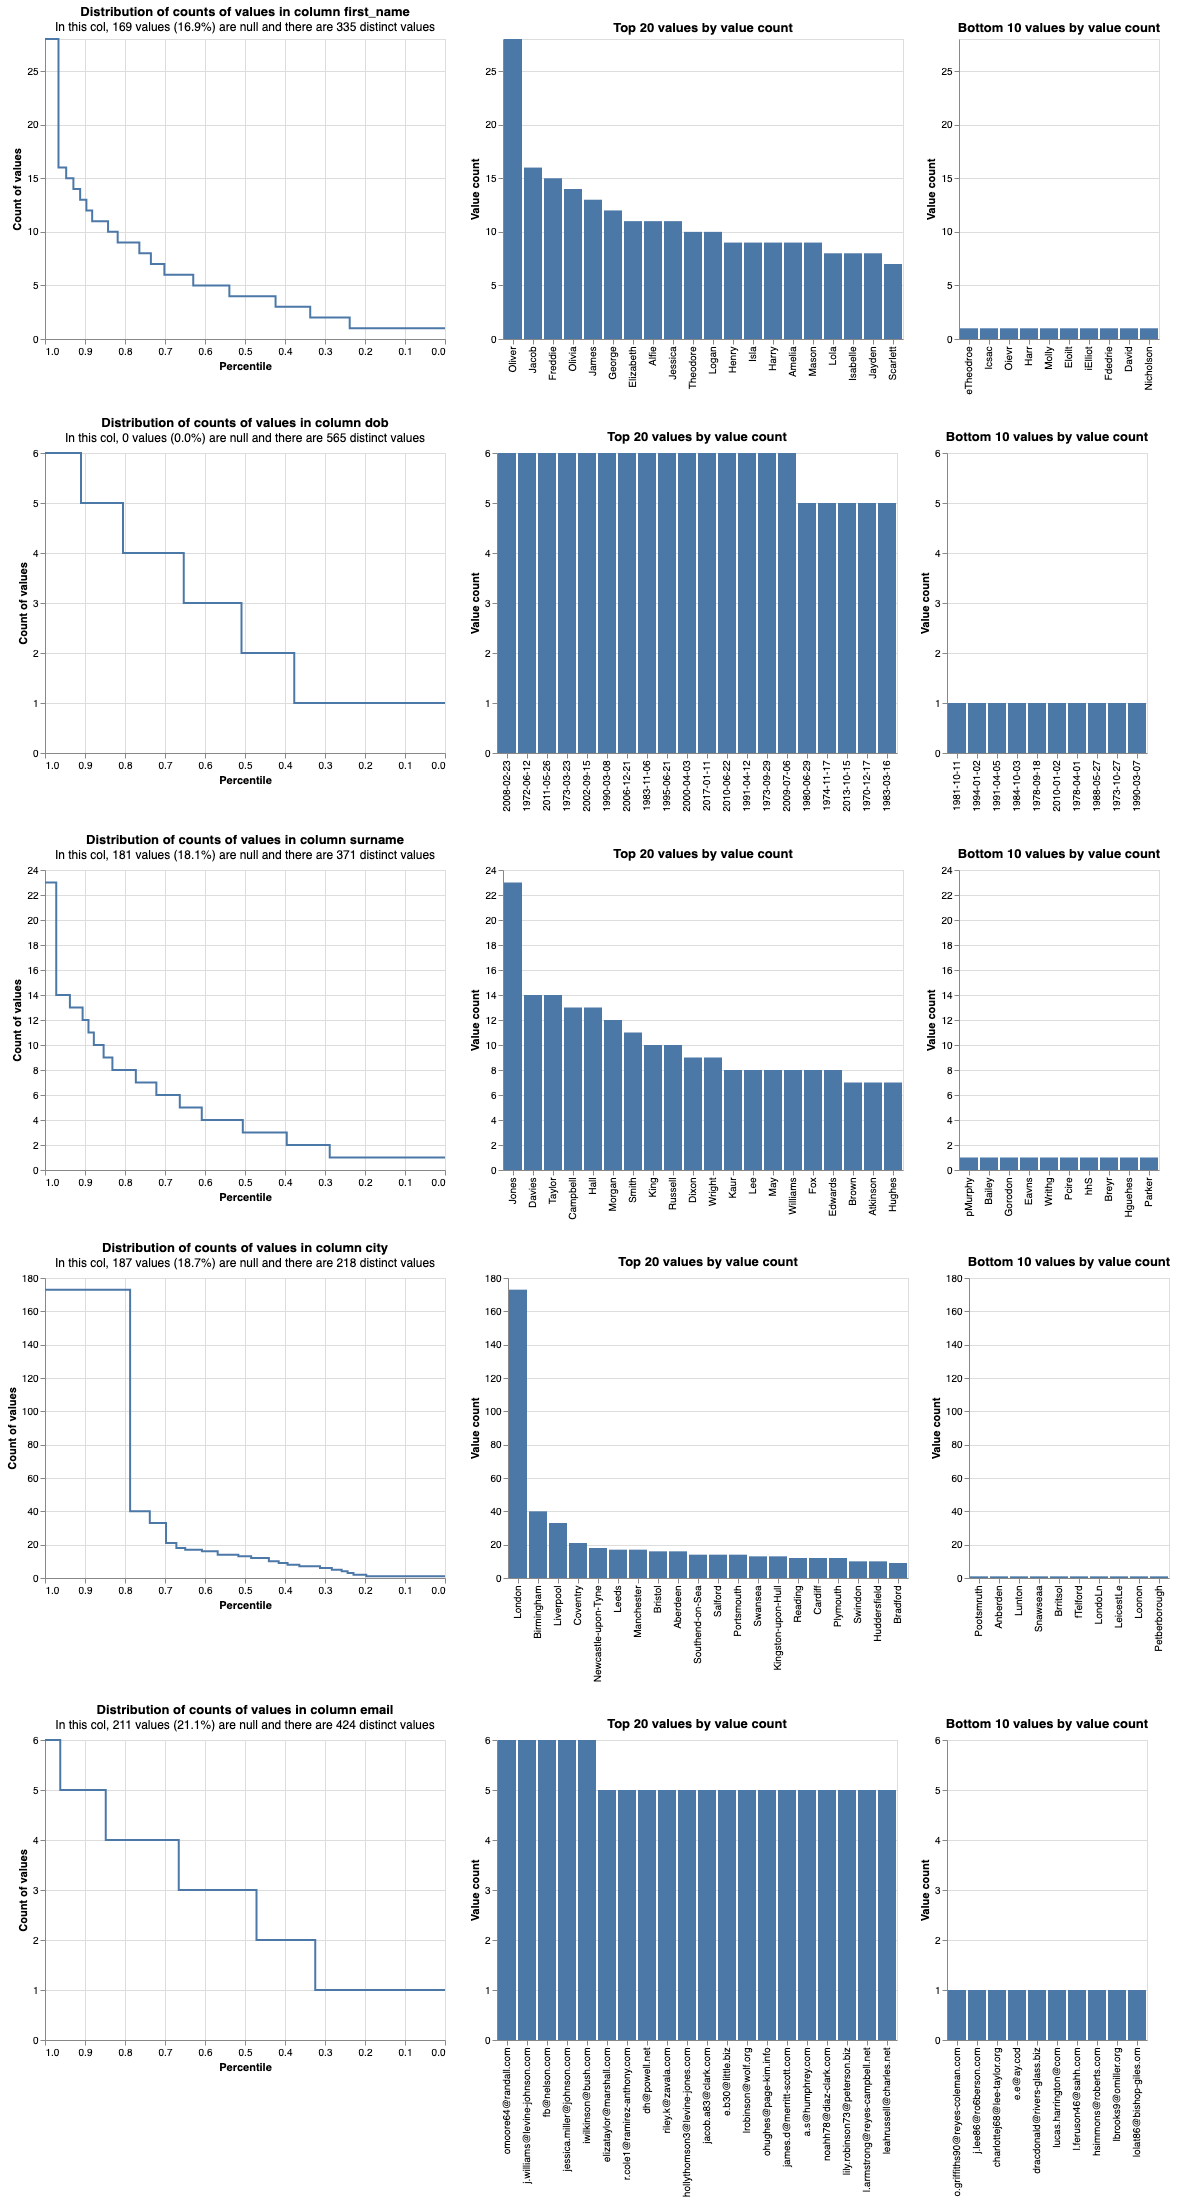

In [6]:
import altair as alt
alt.renderers.enable('mimetype')
column_value_frequencies_chart(['first_name', "surname", "dob", "city", "email"], df, spark)

In this step, with real world data, we would do quite a bit of data cleaning work to do things like standarise names (eg. making them all upper case, splitting out multiple names), cleaning up dates, etc.  Some useful functions are available in [splink_data_standardisation](https://github.com/moj-analytical-services/splink_data_standardisation)

This will be different for every dataset, but the aim is to make it as easy as possible for Splink to spot similarities and difference between fields.

Now that we understand the data, we are ready to start using Splink.

## Step 3: Decide on a blocking approach

In most large datasets, it will be computationally intractable to compare every row with every other row.  We can use a technique called blocking to dramatically reduce the number of comparisons by comparing only records that adhere to certain rules, such as that the first name and date of birth must be equal .  Blocking is described further [here](https://toolkit.data.gov.au/Data_Linking_Information_Series_Sheet_4:_Probabilistic_linking.html).

The above profling charts are useful to understand which blocking rules may be effective.  For example, we can see that that the forename 'George' is the most prevalant in the dataset, occurring 22 times.  If we block on forename, $\frac{n\left(n-1\right)}2$ comparisons will be generated amongst Georges, with each instance being compared to each other.  This is probably viable in terms of the number of comparisons generated.  On the other hand, London appears over 250 times, and so blocking on city would generate a very large number of comparisons where both records had `city = London`.  

Whilst blocking this is useful in reducing record comparisons, the problem is that its rare to find a blocking rule which eliminates enough record comparisons, and does not eliminate true matches (i.e. which has perfect recall).  

The solution to this problem is generally to use several different blocking rules - so for example, to generate record comparisons based on either the rule that first name must be equal, or that surname must be equal.  This means that the blocking approach will only eliminate true comparisons when both first and surname match, which will happen much less often than either one individually.

Unfortuantely, it is theoretically invalid to estimate the Fellegi Sunter model on comparisons generated from multiple blocking rules, becauase it breaks the assumption of conditional independece.

The recommended approach is to estimate different models, one for each blocking rule, and combine the results. 

We will demonstrate how to combined models in a separate notebook.  In this notebook we demonstrate how to run the model for a single rule

## Step 4:  Configure splink using the `settings` object

`splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [7]:
settings = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.first_name = r.first_name"
    ],
    "comparison_columns": [
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city",
            "term_frequency_adjustments": True
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- The blocking rule states that we will all possibly record comparisons where the first_name is equal.
- When comparing records, we will use information from the `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `surname`, string comparisons will have three levels:
    - Level 2: Strings are exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person
- Will will consider the algorithm to have converged when no parameter changes by more than 0.01 between iterations or four iterations.  (Generally we would allow more than four, but this makes the demo run more quickly).

## Step 3:  Estimate u probabilities directly

The u probabilities are the probabilities that fields will match given the records do not match.  So, for example, a 'month of birth' column would be expected to match around 1/12 of the time amongst non-matching records

For many datasets, the probability that two records selected at random will match is almost zero.  A sample of such pairs of records should therefore almost exclusively contain non-matches.  

We can therefore simply assume this dataset contains non-matches only, and directly estimate u probabilities.


In [8]:
from splink.estimate import estimate_u_values
settings_with_u = estimate_u_values(settings, df, spark, fix_u_probabilities=True)

We can see that the `u_probabilities` of the settings dictionary are now populated

In [9]:
from pprint import pprint
pprint(settings_with_u)

{'additional_columns_to_retain': ['group'],
 'blocking_rules': ['l.first_name = r.first_name'],
 'comparison_columns': [{'col_name': 'surname',
                         'fix_u_probabilities': True,
                         'num_levels': 3,
                         'term_frequency_adjustments': True,
                         'u_probabilities': [0.9911783408115926,
                                             0.003931683638285105,
                                             0.004889975550122249]},
                        {'col_name': 'dob',
                         'fix_u_probabilities': True,
                         'u_probabilities': [0.9982522522522522,
                                             0.0017477477477477479]},
                        {'col_name': 'city',
                         'fix_u_probabilities': True,
                         'term_frequency_adjustments': True,
                         'u_probabilities': [0.9448524288198547,
                                        

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm


Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.



In [10]:
from splink import Splink

linker = Splink(settings_with_u, df, spark)
df_e = linker.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.38764194352781056 for key dob, level 1
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.08719883014509955 for key email, level 0
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.029532372546610786 for key email, level 1
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.010158203954784617 for key email, level 0
INFO:splink.iterate:Iteration 4 complete
INFO:splink.model:The maximum change in parameters was 0.0045465469417107635 for key surname, level 0
INFO:splink.iterate:EM algorithm has converged


## Step 5: Inspect results 



In [11]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["match_probability", "match_weight", "unique_id_l","unique_id_r","group_l", "group_r", "surname_l","surname_r","dob_l","dob_r","city_l","city_r","email_l","email_r",]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)

,match_probability,match_weight,unique_id_l,unique_id_r,group_l,group_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r
1547,0.010975,-6.493692,0,1,0,0,Alan,Allen,1971-06-24,1971-05-24,None,None,robert255@smith.net,roberta25@smith.net
1548,0.910519,3.347027,0,3,0,0,Alan,Alen,1971-06-24,1971-06-24,None,Lonon,robert255@smith.net,None
1549,0.956607,4.462391,1,3,0,0,Allen,Alen,1971-05-24,1971-06-24,None,Lonon,roberta25@smith.net,None
717,0.232815,-1.720389,100,330,28,88,None,Richards,2009-08-25,2014-07-10,None,None,e.e@day.com,None
718,0.112617,-2.978139,100,331,28,88,None,None,2009-08-25,2024-07-07,None,Manchester,e.e@day.com,e.richards16@finley.ifo
719,0.112617,-2.978139,100,333,28,88,None,Richards,2009-08-25,2014-07-10,None,Mancester,e.e@day.com,e.richards16@finley.info
268,0.999999,20.177111,101,102,29,29,Griffiths,None,2008-05-07,2008-05-07,Plymouth,Plymouth,a.griffiths@garner-bridges.com,a.griffiths@garner-bridges.com
269,0.910097,3.339577,101,103,29,29,Griffiths,Griffihs,2008-05-07,2009-04-07,Plymouth,Plyoutm,a.griffiths@garner-bridges.com,None
270,1.000000,27.598051,101,105,29,29,Griffiths,Griffiths,2008-05-07,2008-05-07,Plymouth,Plymouth,a.griffiths@garner-bridges.com,a.griffiths@garner-bridges.com
271,0.012038,-6.358757,101,149,29,40,Griffiths,eKelly,2008-05-07,2010-10-09,Plymouth,Birmimghan,a.griffiths@garner-bridges.com,None


We can plot a histogram of the splink match probility.  This chart shows that, for the majority of record comparisons, the match score is estimated to be close to 0 or 1.  This indicates that there are few pairs of records where we are unsure whether it's a match or not.

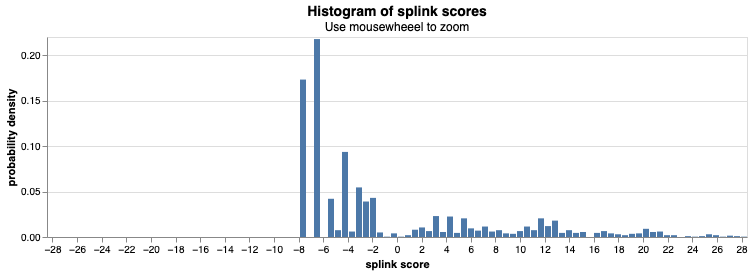

In [12]:
from splink.diagnostics import splink_score_histogram
splink_score_histogram(df_e, spark, 100, "match_weight", symmetric=True)

The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

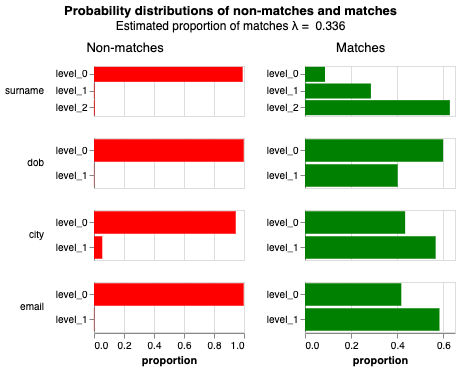

In [13]:
model = linker.model
model.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

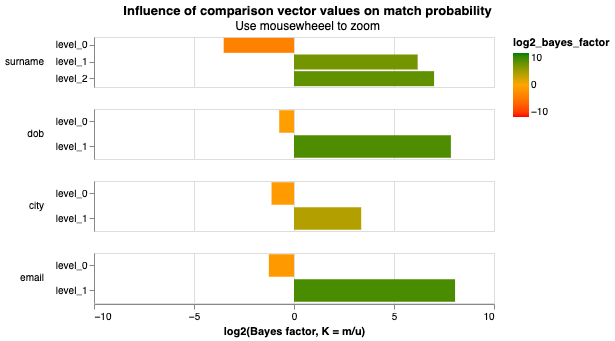

In [14]:
model.bayes_factor_chart()

If charts aren't displaying correctly in your notebook, you can write them to an file, and view them in an IFrame.

In [15]:
from splink.charts import save_offline_chart

chart = model.bayes_factor_chart()
save_offline_chart(chart, filename="bf.html", overwrite=True)

Chart saved to bf.html

To view in Jupyter you can use the following command:

from IPython.display import IFrame
IFrame(src="./bf.html", width=1000, height=500)



You can also output a dashboard of the main charts:

In [16]:
model.all_charts_write_html_file(filename="splink_charts.html", overwrite=True)

You can  generate a chart report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

This uses the Bayes factor to show the relative influence on the final match probability of the λ parameter, and each comparison column for an individual comparison row.

Columns that have no influence on the match score (due to missing data) are not shown.

,match_weight,match_probability,unique_id_l,unique_id_r,surname_l,surname_r,gamma_surname,dob_l,dob_r,gamma_dob,city_l,city_r,gamma_city,email_l,email_r,gamma_email,group_l,group_r
1005,13.79295,0.99993,364,366,Campbell,None,-1,2018-09-24,2018-09-24,1,Newcastle-upon-Tyne,NewcstaTe-upon-lyne,0,samuelcampbell35@hebert.com,samuelcampbell35@hebert.com,1,96,96


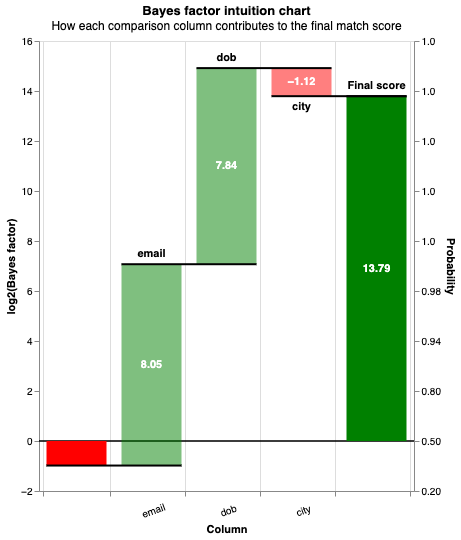

In [17]:
from splink.intuition import bayes_factor_intuition_chart
sample = df_e.toPandas().sample(1)
row_dict = sample.to_dict(orient="records")[0]
display(sample)
bayes_factor_intuition_chart(row_dict, model)

## Step 6: Measure accuracy of results 

If you have labelled data, Splink contains routines to compute various accuracy statistics.

The labelled data should look like this:

| unique_id_l | unique_id_r | clerical_match_score |
|:------------|:------------|---------------------:|
| id1         | id2         |                  0.9 |
| id1         | id3         |                  0.1 |

Since we have labelled data, in this noteboko I create this table from the 'group' field of the original data



**Note: We will fine that the overall accuracy of these results is low because our blocking rule eliminates a large percentage of true matches**

In [18]:
cols = ['unique_id', 'group']
dfpd_l = df.toPandas().sample(300)[cols]
dfpd_l["join_col"] = 1
dfpd_r = dfpd_l.copy()
labels = dfpd_l.merge(dfpd_r, on = "join_col", suffixes=('_l', '_r'))
labels = labels[labels["unique_id_r"]< labels["unique_id_l"]]
labels["clerical_match_score"] = (labels["group_l"] == labels["group_r"]).astype(float)
labels = labels.drop(["group_l", "group_r", "join_col"], axis=1)
labels.head()

,unique_id_l,unique_id_r,clerical_match_score
2,519,350,0.0
3,519,328,0.0
4,519,215,0.0
6,519,4,0.0
7,519,28,0.0


In [19]:
from splink.truth import labels_with_splink_scores, roc_chart, precision_recall_chart
labels_sp = spark.createDataFrame(labels)
labels_and_scores = labels_with_splink_scores(labels_sp, df_e, "unique_id", spark)
labels_and_scores.show()

+-----------+-----------+--------------------+-----------------+-----------------+
|unique_id_l|unique_id_r|clerical_match_score|match_probability|found_by_blocking|
+-----------+-----------+--------------------+-----------------+-----------------+
|        202|          0|                 0.0|              0.0|            false|
|        209|          0|                 0.0|              0.0|            false|
|        233|          0|                 0.0|              0.0|            false|
|         34|          0|                 0.0|              0.0|            false|
|        348|          0|                 0.0|              0.0|            false|
|        377|          0|                 0.0|              0.0|            false|
|        399|          0|                 0.0|              0.0|            false|
|        430|          0|                 0.0|              0.0|            false|
|        434|          0|                 0.0|              0.0|            false|
|   

In [20]:
labels_and_scores_pd = labels_and_scores.toPandas()
f1 = labels_and_scores_pd["clerical_match_score"] == 1.0
labels_and_scores_pd[f1].sample(10)

,unique_id_l,unique_id_r,clerical_match_score,match_probability,found_by_blocking
33084,727,722,1.0,0.000000,False
20136,469,468,1.0,0.000000,False
39226,991,987,1.0,0.000000,False
16743,892,890,1.0,0.000000,False
32997,710,705,1.0,0.000000,False
33507,875,873,1.0,0.000000,False
38131,613,612,1.0,0.000000,False
20106,469,465,1.0,0.000000,False
5501,938,940,1.0,0.999991,True
27772,811,809,1.0,0.000000,False


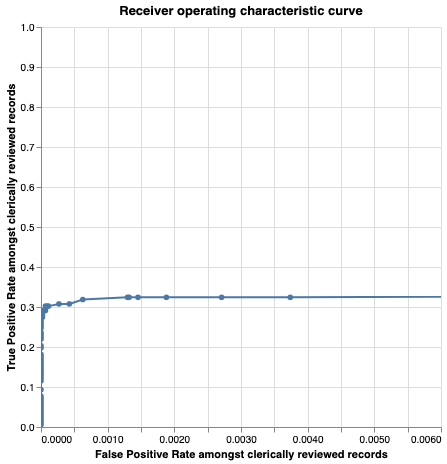

In [21]:
from splink.truth import labels_with_splink_scores, roc_chart, precision_recall_chart


roc_chart(labels_and_scores, spark)

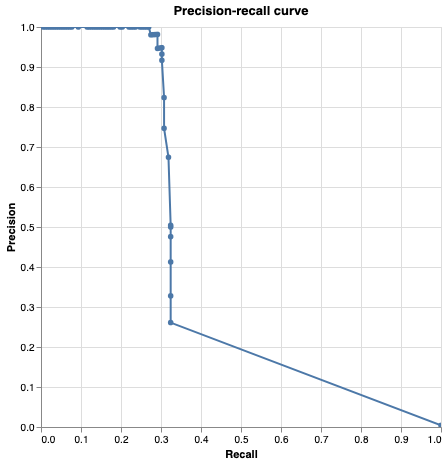

In [22]:
precision_recall_chart(labels_and_scores, spark)

## Step 7: Use graphframes to resolve links into groups

Finally, we can turn the pairwise record comparisons into estimated groups (clusters of records considered to be the same).

You must provide one or more cluster thresholds, which is the match probability above which a pairwise comparison is considered a match

In [23]:
from splink.cluster import clusters_at_thresholds

thresholds = {"cluster_0_5": 0.5, "cluster_0_9": 0.9}
clusters_at_thresholds(df, df_e, thresholds, linker.model).toPandas()

,cluster_0_5,cluster_0_9,unique_id,first_name,surname,dob,city,email,group
0,0,0,1,Robert,Allen,1971-05-24,None,roberta25@smith.net,0
1,1,1,102,Alfie,None,2008-05-07,Plymouth,a.griffiths@garner-bridges.com,29
2,2,2,107,Maisie,Walsh,2005-08-20,Birmingham,maisie.walsh@hodge.com,30
3,3,3,110,Oliver,Atkinnos,2009-12-21,London,oliver.atkinson@moran-smith.com,31
4,4,4,120,Macdonald,Dylan,1986-09-15,Lonodnn,dracdonald@rivers-glass.biz,34
...,...,...,...,...,...,...,...,...,...
995,117,117,972,Leon,Arnmstrong,1970-04-11,Salford,l.armstrong@reyes-campbell.net,245
996,60129542268,60129542268,989,aNncy,Wiliams,1972-02-17,None,None,247
997,60129542269,60129542269,991,Williams,Nancy,1982-01-14,None,None,247
998,42949673090,42949673090,993,Emma,Lloyd,2028-03-13,London,emmallod@jimenez.com,249
